In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from spectral import imshow, view_cube
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import spectral.io.envi as envi

In [3]:
date_dir = '11032019'
num = '9'

dark_ref = envi.open('./{}/dark_ref/capture/dark_ref.hdr'.format(date_dir), './{}/dark_ref/capture/dark_ref.raw'.format(date_dir))
white_ref = envi.open('./{}/white_ref/capture/white_ref.hdr'.format(date_dir), './{}/white_ref/capture/white_ref.raw'.format(date_dir))
data_ref = envi.open('./{}/bisbul_{}_cut/capture/bisbul_{}_cut.hdr'.format(date_dir, num, num), './{}/bisbul_{}_cut/capture/bisbul_{}_cut.raw'.format(date_dir, num, num))

Header parameter names converted to lower case.
Header parameter names converted to lower case.
Header parameter names converted to lower case.


ImageView object:
  Display bands       :  (64, 55, 19)
  Interpolation       :  <default>
  RGB data limits     :
    R: [263.0, 1337.0]
    G: [262.0, 1080.0]
    B: [233.0, 390.0]

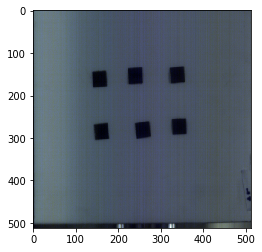

In [4]:
#imshow(data_ref, (110, 5, 18))
white_nparr = np.array(white_ref.load())
dark_nparr = np.array(dark_ref.load())
data_nparr = np.array(data_ref.load())

imshow(data_nparr, (64, 55, 19))

In [5]:
corrected_nparr = np.divide(
    np.subtract(data_nparr, dark_nparr), 
    np.subtract(white_nparr, dark_nparr))

corrected_nparr.shape

(512, 512, 224)

In [6]:
corrected_nparr = corrected_nparr[120:320, 130:380, :]

ImageView object:
  Display bands       :  (32, 32, 32)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.12396693974733353, 1.2920353412628174]
    G: [0.12396693974733353, 1.2920353412628174]
    B: [0.12396693974733353, 1.2920353412628174]

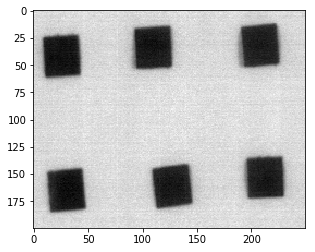

In [7]:
imshow(corrected_nparr, (32, 32, 32))

In [10]:
from numpy import genfromtxt

bands = genfromtxt('./helpers/bands.csv', delimiter=',')

In [11]:
leaf_pixel_y = 150
leaf_pixel_x = 150
teflon_pixel_y = 100
teflon_pixel_x = 100

leaf_pixel = corrected_nparr[
    leaf_pixel_y:leaf_pixel_y+1, 
    leaf_pixel_x:leaf_pixel_x+1, 
    :]
teflon_pixel = corrected_nparr[
    teflon_pixel_y:teflon_pixel_y+1, 
    teflon_pixel_x:teflon_pixel_x+1, 
    :]

leaf_pixel_squeezed = np.squeeze(leaf_pixel)
teflon_pixel_squeezed = np.squeeze(teflon_pixel)

In [14]:
def extract_roi(arr, x, y, w, h, intensity, line):
    roi = arr[y:y+h, x:x+w, :]
    
    bounding_box = arr
    bounding_box[y-line:y, x-line:x+w+line, :] = intensity # garis atas
    bounding_box[y:y+h, x-line:x, :] = intensity # garis kiri
    bounding_box[y+h:y+h+line, x-line:x+w+line, :] = intensity # garis bawah
    bounding_box[y:y+h, x+w:x+w+line, :] = intensity # garis kanan
    
    return (roi, bounding_box)

def extract_rois(coordinates, image, length, intensity, line):
    bounding_boxed = image
    rois = [] # returned ROIs
    for coordinate in coordinates:
        (x, y) = coordinate
        (roi, bounding_boxed) = extract_roi(
            bounding_boxed, x, y, length, length, intensity, line)
        rois.append(roi)
    return rois, bounding_boxed


ImageView object:
  Display bands       :  (64, 55, 19)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.12418300658464432, 2.0]
    G: [0.12773722410202026, 2.0]
    B: [0.14754098653793335, 2.0]

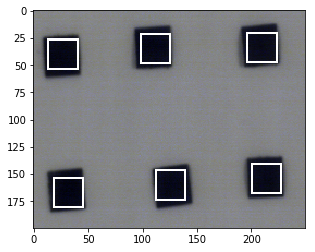

In [15]:
length = 25 # width and height
intensity = 2 # bounding box line intensity
line = 2 # bounding box line width

coordinates = [
    (15, 28),
    (100, 23),
    (198, 22),
    (20, 155),
    (114, 148),
    (202, 142)]

rois, bounding_boxed = extract_rois(coordinates, corrected_nparr, length, intensity, line)

imshow(bounding_boxed, (64, 55, 19))

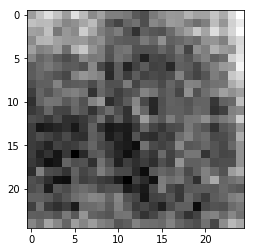

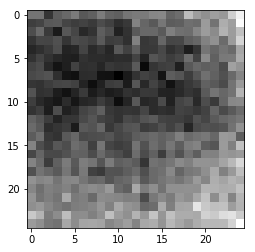

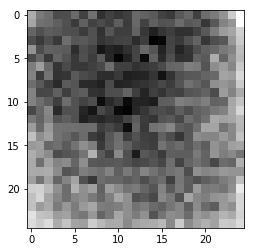

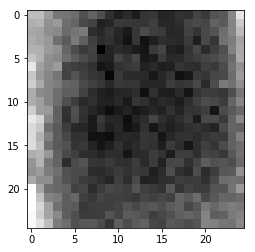

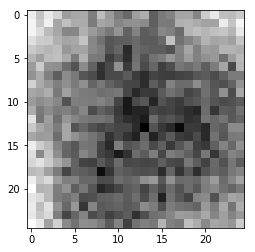

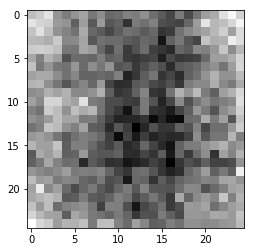

In [16]:
for item in rois:
    imshow(item, (100, 100, 100))

In [17]:
np.save("{}/bisbul_{}_rois.npy".format(date_dir, num), rois)
np.save("{}/bisbul_{}_corrected.npy".format(date_dir, num), corrected_nparr)

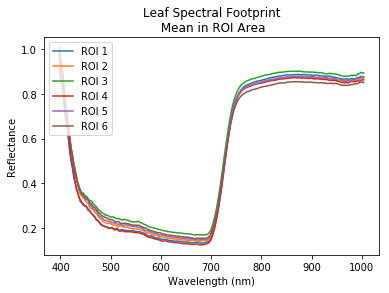

In [18]:
for i in range(len(rois)):
    roi = rois[i]
    intensity = []
    for b in range(roi.shape[2]):
        intensity.append(np.mean(roi[:, :, b]))
    plt.plot(bands, intensity, label='ROI {}'.format(i+1))
    
plt.legend(loc='upper left')
plt.title('Leaf Spectral Footprint\n Mean in ROI Area')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()